In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

In [2]:
import fastNLP
from fastNLP.io.dataset_loader import CSVLoader
from fastNLP import Batch
from fastNLP import Vocabulary
from fastNLP import RandomSampler, SequentialSampler
from fastNLP.io.embed_loader import EmbedLoader

## Part1. Text classification using CNN with random word embedding
### 1. Hyperparameter

In [3]:
batch_size = 64
learning_rate = 0.0001
num_epoch = 5
num_kernel = 128
dropout_rate = 0.5
use_pretrain = 0
freeze_pretrain = 1
embed_path = 'data/glove.6B.100d.txt'
embedding_size = 100

loss_history = []
load_address = None
use_cuda = torch.cuda.is_available()
print("use_cuda: ", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

use_cuda:  True


### 2. data preprocess

In [4]:
def get_word(x):
    if(x == ' '):
        return [' ']
    else:
        return x.lower().split()

def load_data(path, is_train = 0):
    loader = CSVLoader(sep='\t')
    dataset = loader.load(path)
    dataset.delete_field('SentenceId')
    dataset.delete_field('PhraseId')
    
    dataset.apply(lambda x: get_word(x['Phrase']), new_field_name = 'words', is_input = True)
    dataset.apply(lambda x: len(x['words']), new_field_name = "length", is_input = True)
    dataset.delete_field('Phrase')
    if(is_train):
        dataset.apply(lambda x: int(x['Sentiment']), new_field_name = "Sentiment")
        dataset.set_target('Sentiment')
    return dataset

In [5]:
# 1. get dataset
dataset = load_data('data/train.tsv', 1)
train_dataset, val_dataset = dataset.split(0.1)
test_dataset = load_data('data/test.tsv', 0)
print("train_dataset size: ", train_dataset.get_length())
print("val_dataset size: ", val_dataset.get_length())
print("test_dataset size: ", test_dataset.get_length())

train_dataset size:  140454
val_dataset size:  15606
test_dataset size:  66292


In [6]:
# 2. get vocabulary
if(use_pretrain):
    loader = EmbedLoader()
    # 同时fastNLP随机初始化了<pad>&<unk>的embedding
    pre_embed, vocab = loader.load_without_vocab(embed_path, normalize = False)
    embeddig_size = pre_embed.shape[1]
else:
    vocab = Vocabulary(min_freq=2).from_dataset(dataset, field_name='words')
print("vocabulary size: ", len(vocab))

vocabulary size:  16507


In [7]:
# 3. word to index
vocab.index_dataset(train_dataset, field_name='words',new_field_name='words')
vocab.index_dataset(val_dataset, field_name='words',new_field_name='words')
vocab.index_dataset(test_dataset, field_name='words',new_field_name='words')

### 3. Build CNN model

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.embedding = nn.Embedding(len(vocab), embedding_size, padding_idx = vocab['<pad>'])
        if(use_pretrain):
            self.embedding.from_pretrained(torch.Tensor(pre_embed), freeze = bool(freeze_pretrain))
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = num_kernel, kernel_size = (2, embedding_size))
        self.conv2 = nn.Conv2d(in_channels = 1, out_channels = num_kernel, kernel_size = (3, embedding_size))
        self.conv3 = nn.Conv2d(in_channels = 1, out_channels = num_kernel, kernel_size = (4, embedding_size))
        self.relu = nn.ReLU()
        self.pooling = nn.AdaptiveMaxPool2d(1)
        self.dropout = nn.Dropout(p = dropout_rate)
        self.classifier = nn.Sequential(
            nn.Linear(num_kernel * 3, 5)
        )

    def forward(self, x, lengths):
        N = x.shape[0]
        x = self.embedding(x) # [N, T, E]
        x = x.view(N, 1, x.shape[1], x.shape[2])
        conv1 = self.pooling(self.relu(self.conv1(x))).view((N, -1))
        conv2 = self.pooling(self.relu(self.conv2(x))).view((N, -1))
        conv3 = self.pooling(self.relu(self.conv3(x))).view((N, -1))
        x = torch.cat((conv1, conv2, conv3), dim = 1)
        x = self.dropout(x)
        score = self.classifier(x)
        return score
    
model = CNN()
# model = nn.DataParallel(model)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
if(load_address is not None):
    model = torch.load(load_address)

In [9]:
print(model.named_modules)

<bound method Module.named_modules of CNN(
  (embedding): Embedding(16507, 100, padding_idx=0)
  (conv1): Conv2d(1, 128, kernel_size=(2, 100), stride=(1, 1))
  (conv2): Conv2d(1, 128, kernel_size=(3, 100), stride=(1, 1))
  (conv3): Conv2d(1, 128, kernel_size=(4, 100), stride=(1, 1))
  (relu): ReLU()
  (pooling): AdaptiveMaxPool2d(output_size=1)
  (dropout): Dropout(p=0.5)
  (classifier): Sequential(
    (0): Linear(in_features=384, out_features=5, bias=True)
  )
)>


### 4. Train Model

In [10]:
def model_status(training):
    if(training):
        return 'model is in training'
    else:
        return 'model is in testing'

In [11]:
def pack(batch_x, batch_y, is_train = 1):
    x = batch_x['words']
    lengths = batch_x['length']
    index = torch.argsort(lengths, descending = True)
    x = x[index].to(device)
    lengths = lengths[index].to(device)
    if(is_train):
        y = batch_y['Sentiment']
        y = y[index].to(device)
        return x, lengths, y
    else:
        return x, lengths

In [12]:
def predict(model, dataset):
    model.eval()
    print(model_status(model.training))
    num_correct = torch.tensor(0.0)
    num_sample = torch.tensor(0.0)
    for batch_x, batch_y in Batch(dataset, sampler = SequentialSampler(), batch_size = batch_size):
        x, lengths, y = pack(batch_x, batch_y)
        score = model(x, lengths)
        y_predict = torch.argmax(score, dim = 1)
        num_correct += torch.sum(y_predict == y)
        num_sample += x.shape[0]
    return 1.0 * num_correct / num_sample

In [13]:
def train(model, dataset, optimizer, num_epoch = 30):
    loss_history = []
    for i in range(num_epoch):
        print("Epoch: {0} start".format(i))
        model.train()
        print(model_status(model.training))
        losses = 0
        for batch_x, batch_y in Batch(dataset, sampler = RandomSampler(), batch_size = batch_size):
            x, lengths, y = pack(batch_x, batch_y)
            optimizer.zero_grad()
            score = model(x, lengths)
            loss_fn = nn.CrossEntropyLoss().to(device)
            loss = loss_fn(score, y)
            loss.backward()
            losses += loss
            optimizer.step()
        print("Epoch: {0} finish".format(i))
        loss_history.append(losses)
        acc = predict(model, val_dataset[0:100])
        print("Epoch: {0}, loss: {1}, accu: {2}\n".format(i, losses, acc))
    return loss_history

loss_history_new = train(model, train_dataset[0:1000], optimizer, num_epoch = 100)

Epoch: 0 start
model is in training
Epoch: 0 finish
model is in testing
Epoch: 0, loss: 26.2403564453125, accu: 0.17000000178813934

Epoch: 1 start
model is in training
Epoch: 1 finish
model is in testing
Epoch: 1, loss: 23.70697021484375, accu: 0.38999998569488525

Epoch: 2 start
model is in training
Epoch: 2 finish
model is in testing
Epoch: 2, loss: 22.708452224731445, accu: 0.47999998927116394

Epoch: 3 start
model is in training
Epoch: 3 finish
model is in testing
Epoch: 3, loss: 22.393625259399414, accu: 0.5

Epoch: 4 start
model is in training
Epoch: 4 finish
model is in testing
Epoch: 4, loss: 21.850229263305664, accu: 0.47999998927116394

Epoch: 5 start
model is in training
Epoch: 5 finish
model is in testing
Epoch: 5, loss: 21.4749698638916, accu: 0.5

Epoch: 6 start
model is in training
Epoch: 6 finish
model is in testing
Epoch: 6, loss: 21.393253326416016, accu: 0.5

Epoch: 7 start
model is in training
Epoch: 7 finish
model is in testing
Epoch: 7, loss: 20.658212661743164, 

model is in training
Epoch: 62 finish
model is in testing
Epoch: 62, loss: 8.616268157958984, accu: 0.5099999904632568

Epoch: 63 start
model is in training
Epoch: 63 finish
model is in testing
Epoch: 63, loss: 8.686956405639648, accu: 0.5199999809265137

Epoch: 64 start
model is in training
Epoch: 64 finish
model is in testing
Epoch: 64, loss: 8.793126106262207, accu: 0.5099999904632568

Epoch: 65 start
model is in training
Epoch: 65 finish
model is in testing
Epoch: 65, loss: 8.425320625305176, accu: 0.5099999904632568

Epoch: 66 start
model is in training
Epoch: 66 finish
model is in testing
Epoch: 66, loss: 8.301085472106934, accu: 0.5099999904632568

Epoch: 67 start
model is in training
Epoch: 67 finish
model is in testing
Epoch: 67, loss: 8.036895751953125, accu: 0.5099999904632568

Epoch: 68 start
model is in training
Epoch: 68 finish
model is in testing
Epoch: 68, loss: 7.841493129730225, accu: 0.5099999904632568

Epoch: 69 start
model is in training
Epoch: 69 finish
model is i

### 6. Get Result

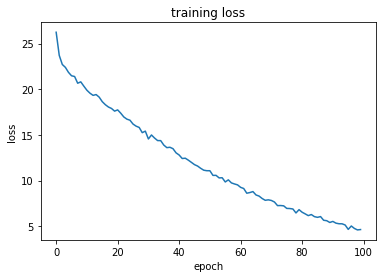

In [14]:
def plot(plt):
    plt.title("training loss")
    plt.xlabel("epoch")
    plt.ylabel('loss')
    plt.plot(range(len(loss_history)), loss_history)
    return plt

loss_history += loss_history_new
plt.figure(0)
plot(plt)
plt.show()

In [16]:
def get_answer(model, dataset):
    answer = []
    model.eval()
    print("start to generate result")
    print(model_status(model.training))
    for batch_x, batch_y in Batch(dataset, sampler = SequentialSampler(), batch_size = batch_size):
        x, lengths = pack(batch_x, batch_y, 0)
        score = model(x, lengths)
        y_predict = torch.argmax(score, dim = 1).cpu().numpy()
        answer += list(y_predict)
    index = [a + 156061 for a in range(len(answer))]
    dataframe = pd.DataFrame({'PhraseId':index, 'Sentiment':answer})
    name = "result/CNN_pretrain" + str(use_pretrain) + "_freeze" + str(freeze_pretrain) + "_kernel" + str(num_kernel) + "dropouot" + str(dropout_rate) + "_random_batch_size" + str(batch_size) + "_lr" + str(learning_rate) + "_epoch" + str(num_epoch) + "_embedding" + str(embedding_size)+".csv"
    dataframe.to_csv(name,index=False,sep=',')
    return answer

answer = get_answer(model, test_dataset[0:10])

start to generate result
model is in testing
